In [248]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from numba import jit

* $Ackley(x) = -a * exp(-b \sqrt{\frac{1}{d}\sum_{i=1}^{d}x_i^2}) - exp(\frac{1}{d}\sum_{i=1}^{d}cos(cx_i)) + a + e$
* $Dixon\_Price(x) = (x_i - 1)^2 + \sum_{i=2}^{d}i(2x_i^2 - x_{i-1})^2$
* $Rosenbrock(x) = \sum_{i=1}^{d-1} \left[ 100(x_{i+1}-x_i^2)^2 + (x_i - 1)^2 \right]$
* $Griewank(x) = \sum_{i=i}^{d}\frac{x_i^2}{4000} - \Pi_{i=1}^{d}cos(\frac{x_i}{\sqrt{i}}) + 1$

In [328]:
@jit(nopython=True)
def Ackley(X):
    n = len(X)
    a = 20
    b = 0.2
    c = 2 * np.pi

    return -a * np.exp(- b * np.sqrt((X @ X)/n)) - np.exp((np.cos(c * X)).sum()/n) + a + np.e

@jit(nopython=True)
def Dixon_Price(X):
    n = len(X)
    return (X[0] - 1)**2 + (np.arange(2, n+1) * (2*X[1:]**2 - X[:-1])**2).sum()

@jit(nopython=True)
def Rosenbrock(X):
    return (100*(X[1:]-X[:-1]**2) + (X[:-1]**2)).sum()


@jit(nopython=True)
def Griewank(X):
    n = len(X)
    return ((X**2).sum())/4000 - np.cos(X/np.sqrt(np.arange(1, n+1))).prod() + 1

@jit(nopython=True)
def Schwefel(X):
    n = len(X)
    s = 0
    for xi in X:
        s += xi * np.sin(np.sqrt(xi))
    return 418.9829*n - s
    # return np.random.randint(0, 100)



In [329]:
def random_individual(n, min_bound=0, max_bound=1):
    values = [np.random.rand() * (max_bound - min_bound) + min_bound for _ in range(n)]

    return values

def random_sigma_chromosome(n):
    return [np.random.randn() for _ in range(n)]

def random_population(N, n, min_bound=0, max_bound=1):
    values = np.array([random_individual(n, min_bound, max_bound) for _ in range(N)])
    sigmas = np.array([random_sigma_chromosome(n) for _ in range(N)])

    return values, sigmas

@jit(nopython=True)
def population_evaluation(P, F):
    scores = np.zeros(len(P))
    for i in range(len(scores)):
        scores[i] = F(P[i])

    return scores

def parent_selection(P, scores, n_offspring):
    population_size = len(P)

    fitness_values = scores.max() - scores
    # print(scores)
    # print(fitness_values)
    if fitness_values.sum() > 0:
        fitness_values = fitness_values / fitness_values.sum()
    else:
        fitness_values = np.ones(population_size) / population_size

    # print(fitness_values)

    parent_indices = np.random.choice(population_size, n_offspring, True, fitness_values).astype(np.int64)

    return parent_indices

def mutation(P, S, tau, tau0):
    N = len(P)
    n = len(P[0])
    for i in range(N):
        epsilon0 = np.random.randn() * tau0
        epsilons = np.random.randn(n) * tau

        S[i] = S[i] * np.exp(epsilons + epsilon0)

        epsilons = np.random.randn(n) * S[i]

        P[i] += epsilons
        

def ES(F, c_len, population_size, offspring_size, tau, tau0, iterations, min_bound=-5, max_bound=5, plus=True):
    P, S = random_population(population_size, c_len, min_bound, max_bound)
    scores = population_evaluation(P, F)

    history = []
    history.append(P)
    
    history_scores = []
    history_scores.append(scores)
    
    for _ in tqdm(range(iterations)):
        c_ind = parent_selection(P, scores, offspring_size)
        P_c = P[c_ind]
        S_c = S[c_ind]

        # print(P_c)
        mutation(P_c, S_c, tau, tau0)

        scores_c = population_evaluation(P_c, F)

        # Replacement

        if plus:
            P_all = np.vstack((P, P_c))
            S_all = np.vstack((S, S_c))
        else:
            P_all = P_c
            S_all = S_c

        scores_all = np.hstack((scores, scores_c))

        sorted_scores_ind = np.argsort(scores_all)

        P = P_all[sorted_scores_ind[:population_size]]
        S = S_all[sorted_scores_ind[:population_size]]
        scores = scores_all[sorted_scores_ind[:population_size]]
        # print(scores.min(), scores.mean(), scores.max())
        # stats.append((scores.min(), scores.mean(), scores.max()))
        history.append(P)
        history_scores.append(scores)

    return history, history_scores



In [269]:
def plot_min_max_mean(populations_objective_values):
    line_width = 1.5
    ea_means = np.mean(populations_objective_values, axis=1)
    ea_maxs = np.max(populations_objective_values, axis=1)
    ea_mins = np.min(populations_objective_values, axis=1)

    plt.figure(figsize=[12, 7])

    plt.axis(True)
    plt.grid(True)

    plt.plot(ea_means, linewidth=1.5, label="mean")
    plt.plot(ea_mins, linewidth=1.5, label="min")
    plt.plot(ea_maxs, linewidth=1.5, label="max")
    plt.legend()
    plt.show()

100%|██████████| 2000/2000 [00:21<00:00, 92.17it/s]


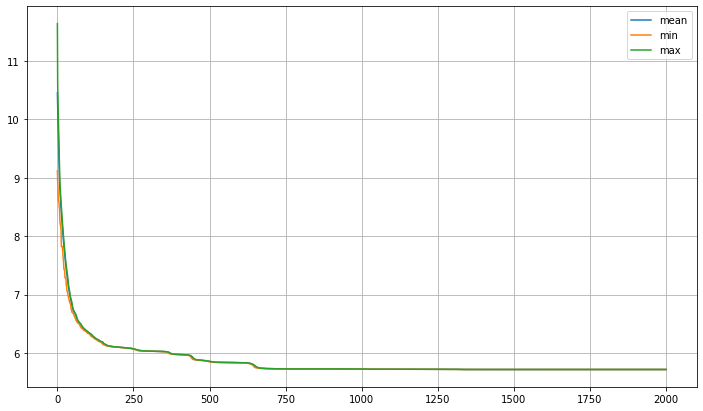

In [280]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Ackley, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, iterations=2000)

plot_min_max_mean(scores)

100%|██████████| 200/200 [00:01<00:00, 180.87it/s]


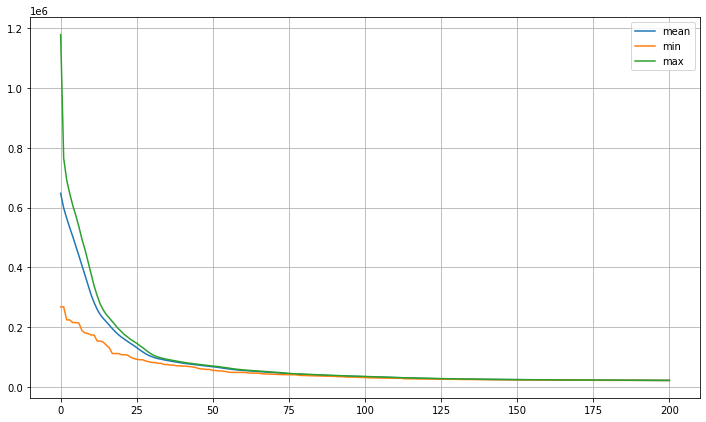

In [284]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Dixon_Price, c_len=l, population_size=1000, offspring_size=500, tau=t, tau0=t0, iterations=200)

plot_min_max_mean(scores)

100%|██████████| 1000/1000 [00:10<00:00, 91.58it/s]


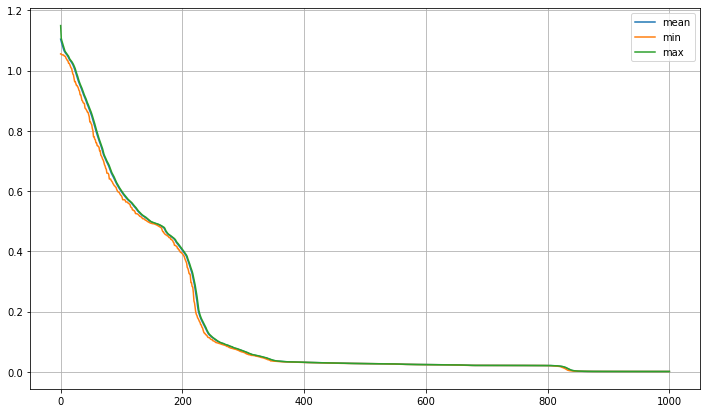

In [291]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Griewank, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, iterations=1000)

plot_min_max_mean(scores)

100%|██████████| 500/500 [00:05<00:00, 97.08it/s]


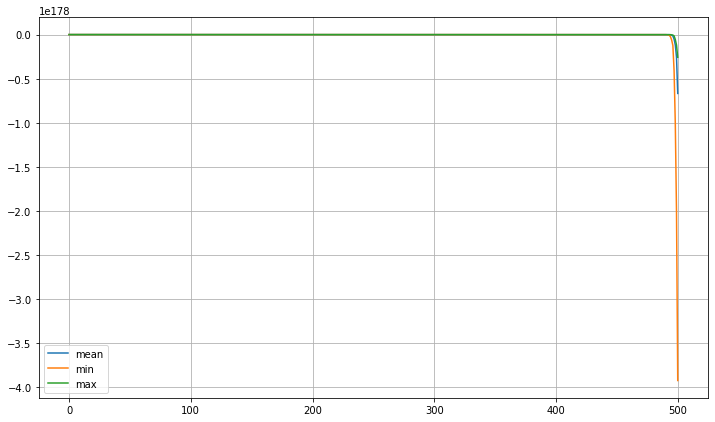

In [303]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Rosenbrock, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, iterations=500)

plot_min_max_mean(scores)

In [ ]:
l = 50
t = 1/np.sqrt(2*l)
t0 = 1/np.sqrt(2*np.sqrt(l))

populations, scores = ES(F=Schwefel, c_len=l, population_size=1000, offspring_size=1000, tau=t, tau0=t0, min_bound=-200, max_bound=200, iterations=100)

plot_min_max_mean(scores)